<a href="https://colab.research.google.com/github/Juan-Garassino/bitcoin-time-series/blob/master/bitcoin-time-series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 1

plt.style.available
plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = "#ffffff"

# CSV

In [170]:
!pip install pmdarima

!pip install statsmodels

In [171]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm

## Bitcoin

In [172]:
"""
Alias    Description
B        business day frequency
C        custom business day frequency
D        calendar day frequency
W        weekly frequency
M        month end frequency
SM       semi-month end frequency (15th and end of month)
BM       business month end frequency
CBM      custom business month end frequency
MS       month start frequency
SMS      semi-month start frequency (1st and 15th)
BMS      business month start frequency
CBMS     custom business month start frequency
Q        quarter end frequency
BQ       business quarter end frequency
QS       quarter start frequency
BQS      business quarter start frequency
A, Y     year end frequency
BA, BY   business year end frequency
AS, YS   year start frequency
BAS, BYS business year start frequency
BH       business hour frequency
H        hourly frequency
T, min   minutely frequency
S        secondly frequency
L, ms    milliseconds
U, us    microseconds
N        nanoseconds
"""

'\nAlias    Description\nB        business day frequency\nC        custom business day frequency\nD        calendar day frequency\nW        weekly frequency\nM        month end frequency\nSM       semi-month end frequency (15th and end of month)\nBM       business month end frequency\nCBM      custom business month end frequency\nMS       month start frequency\nSMS      semi-month start frequency (1st and 15th)\nBMS      business month start frequency\nCBMS     custom business month start frequency\nQ        quarter end frequency\nBQ       business quarter end frequency\nQS       quarter start frequency\nBQS      business quarter start frequency\nA, Y     year end frequency\nBA, BY   business year end frequency\nAS, YS   year start frequency\nBAS, BYS business year start frequency\nBH       business hour frequency\nH        hourly frequency\nT, min   minutely frequency\nS        secondly frequency\nL, ms    milliseconds\nU, us    microseconds\nN        nanoseconds\n'

In [173]:
RESAMPLE = "W" # BEST = "W"
FREQ = 145 # BEST = 145
LAGS_BIAS = 0.25
TRAIN_SIZE = 0.70

STYLE = "#ffffff" # "#383838"

In [174]:
bitcoin = pd.read_csv("/content/drive/MyDrive/Data/Bitcoin_2010_2021.csv") #.dropna()

bitcoin["date"] = pd.to_datetime(bitcoin["Timestamp"], unit='s') # Unit Seconds

bitcoin["log"] = np.log(bitcoin["Weighted_Price"])

bitcoin = bitcoin.set_index("date").interpolate() # pandas.DataFrame.asfreq

In [175]:
bitcoin.shape # Total amount of samples

(4727777, 9)

In [176]:
START = bitcoin.index.searchsorted(dt.datetime(2012, 1, 1))
END = bitcoin.index.searchsorted(dt.datetime(2021, 1, 1))

bitcoin = bitcoin.iloc[START:END]

bitcoin = bitcoin.resample(RESAMPLE).mean().interpolate()

In [177]:
bitcoin.shape # Resample amount of samples

(471, 9)

In [178]:
bitcoin

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,log
date,,,,,,,,,
2012-01-01,1.325419e+09,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576,1.560813
2012-01-08,1.325765e+09,5.938663,5.948863,5.938651,5.948851,6.837477,37.261783,5.942655,1.773830
2012-01-15,1.326370e+09,6.763291,6.764704,6.753707,6.755134,3.011501,20.912794,6.758309,1.909429
2012-01-22,1.326974e+09,6.535994,6.537661,6.535481,6.537147,6.379923,40.532655,6.536304,1.875073
2012-01-29,1.327579e+09,5.977846,5.977902,5.977837,5.977893,4.369383,27.128929,5.977894,1.782728
...,...,...,...,...,...,...,...,...,...
2020-12-06,1.606997e+09,19097.039229,19109.353821,19084.282120,19097.424118,4.615430,88187.345351,19097.138202,9.857182
2020-12-13,1.607602e+09,18604.487024,18613.348548,18595.613012,18604.797295,4.013421,74192.523003,18604.559073,9.830835
2020-12-20,1.608206e+09,21578.435459,21592.311917,21563.691285,21578.618057,7.253280,159226.938237,21578.338026,9.975666


In [179]:
decomp_add = seasonal_decompose(bitcoin["Weighted_Price"], model="additive", period = FREQ)

decomp_mult = seasonal_decompose(bitcoin["Weighted_Price"], model="multiplicative", period = FREQ)

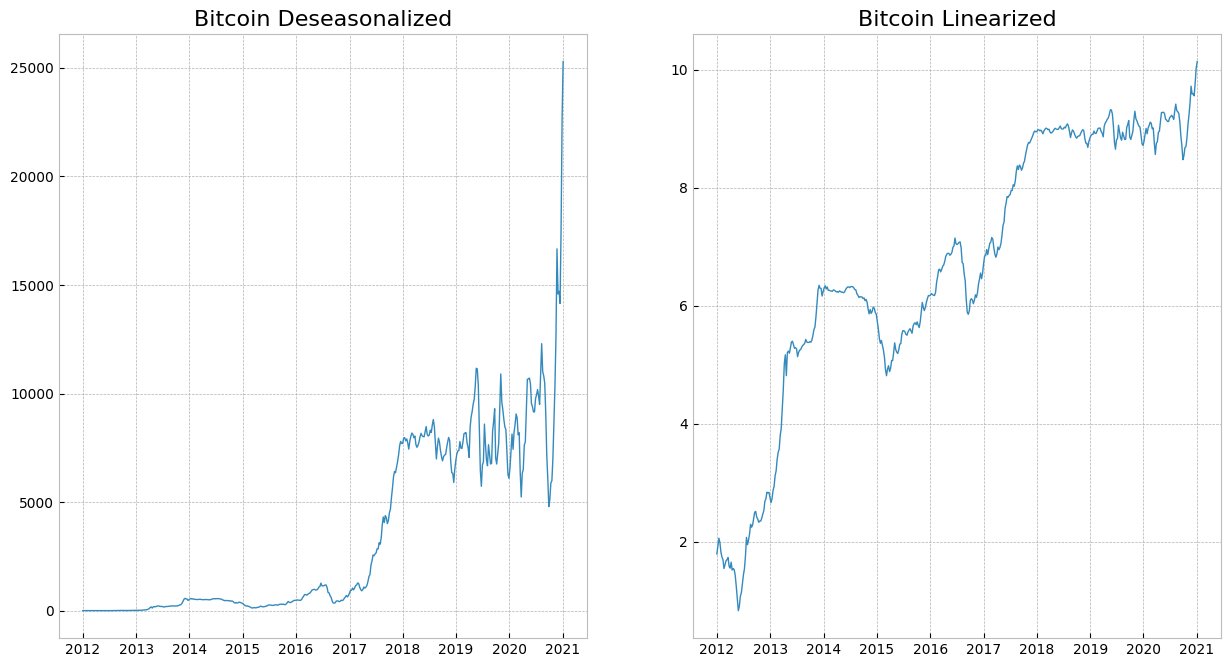

In [180]:
# Let's remove seasons
bitcoin['deseasonalized'] = bitcoin["Weighted_Price"].values / decomp_mult.seasonal

plt.figure(figsize=(15, 8), dpi = 100, facecolor = (STYLE));
plt.subplot(1,2,1);
plt.plot(bitcoin.deseasonalized, linewidth=1);
plt.title('Bitcoin Deseasonalized', fontsize = 16);

# Also remove exponential trend 
bitcoin['linearized'] = np.log(bitcoin['deseasonalized'])

plt.subplot(1,2,2);
plt.plot(bitcoin['linearized'], linewidth=1)
plt.title('Bitcoin Linearized', fontsize = 16);

In [181]:
difference = pd.DataFrame()

difference["Normal differencing"] = bitcoin["linearized"].diff(1)
difference["Seasonal differencing"] = bitcoin["linearized"].diff(FREQ)
difference["Sesonal + Normal differencing"] = bitcoin["linearized"].diff(FREQ).diff(1)

difference = difference.dropna()

In [182]:
# Create a correct Training/Test split

index = round(TRAIN_SIZE * bitcoin.shape[0])

bitcoin_train = bitcoin.iloc[:index]

bitcoin_test = bitcoin.iloc[index+1:]

## Seasonal Decomposition

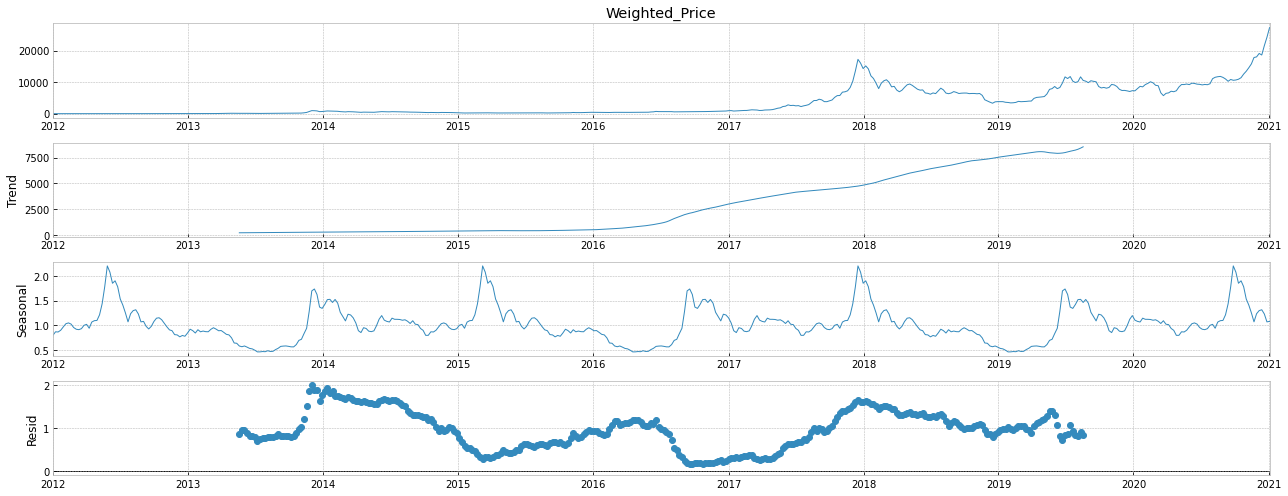

In [183]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(18,7), facecolor = (STYLE))
    mpl.rc('lines', linewidth=1, color = "r")
    decomp_mult.plot();

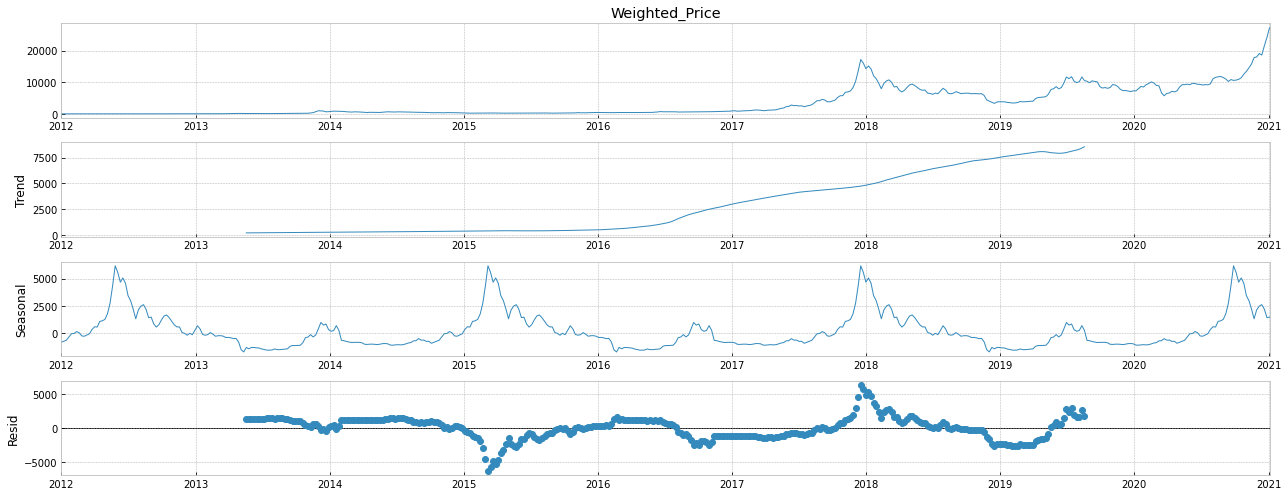

In [184]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(18,7), facecolor = (STYLE))
    mpl.rc('lines', linewidth=1, color = "r")
    decomp_add.plot();

## STEP 1 | Stationarity

In [185]:
# check with ADF Test for stationarity

print('p-value zero-diff: ', adfuller(bitcoin_train.linearized)[1])
print('p-value first-diff: ', adfuller(bitcoin_train.linearized.diff(FREQ).dropna())[1])
print('p-value second-diff: ', adfuller(bitcoin_train.linearized.diff(FREQ).diff().dropna())[1])

p-value zero-diff:  0.7318472431805065
p-value first-diff:  0.6247642652880372
p-value second-diff:  7.688966850159802e-09


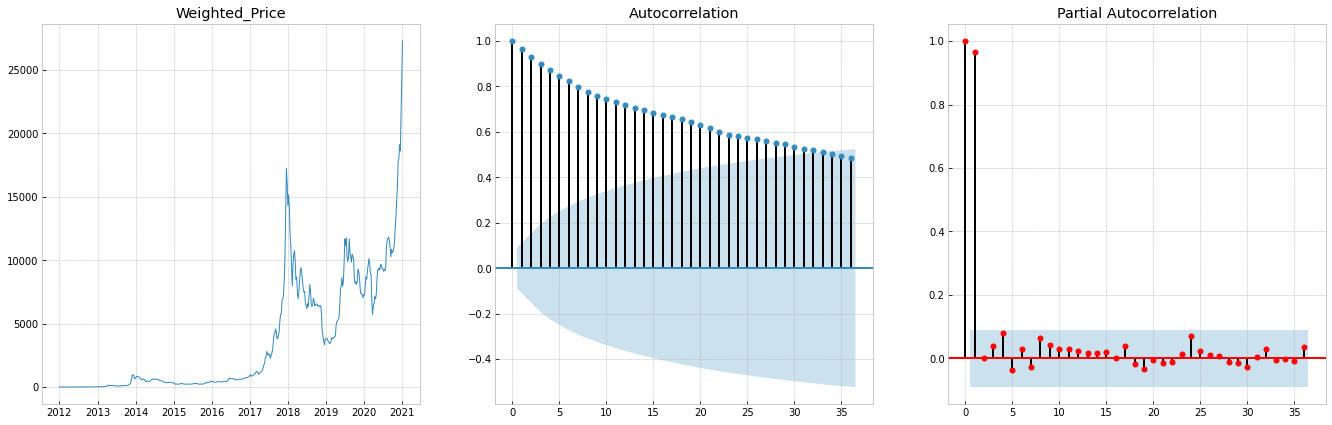

In [186]:
y = bitcoin["Weighted_Price"]

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))
axes[0].plot(y, linewidth=1); axes[0].set_title('Weighted_Price')
plot_acf(y, ax = axes[1], lags = FREQ * LAGS_BIAS);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS);

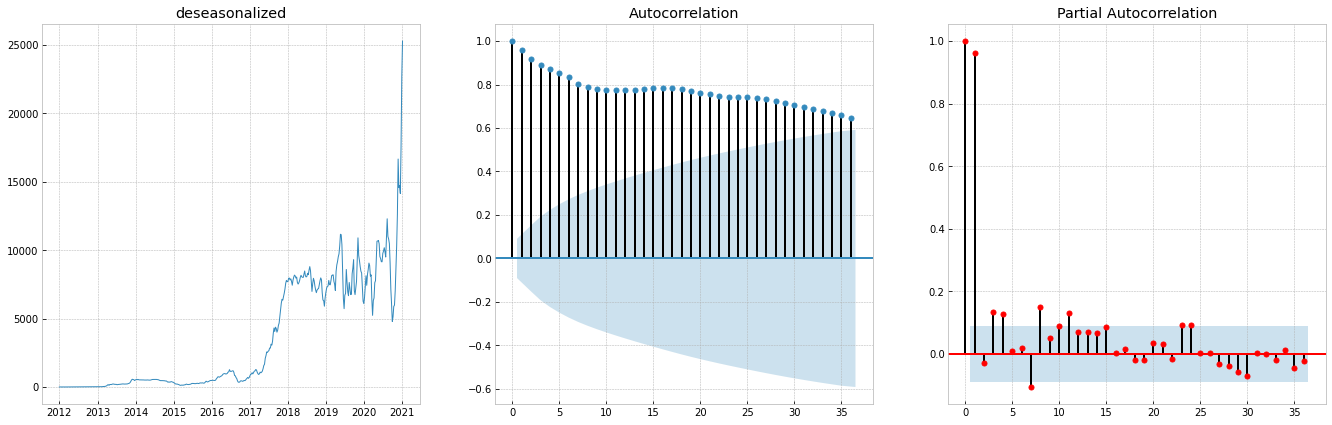

In [187]:
y = bitcoin["deseasonalized"]

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))
axes[0].plot(y, linewidth=1); axes[0].set_title('deseasonalized')
plot_acf(y, ax = axes[1], lags = FREQ * LAGS_BIAS);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS);

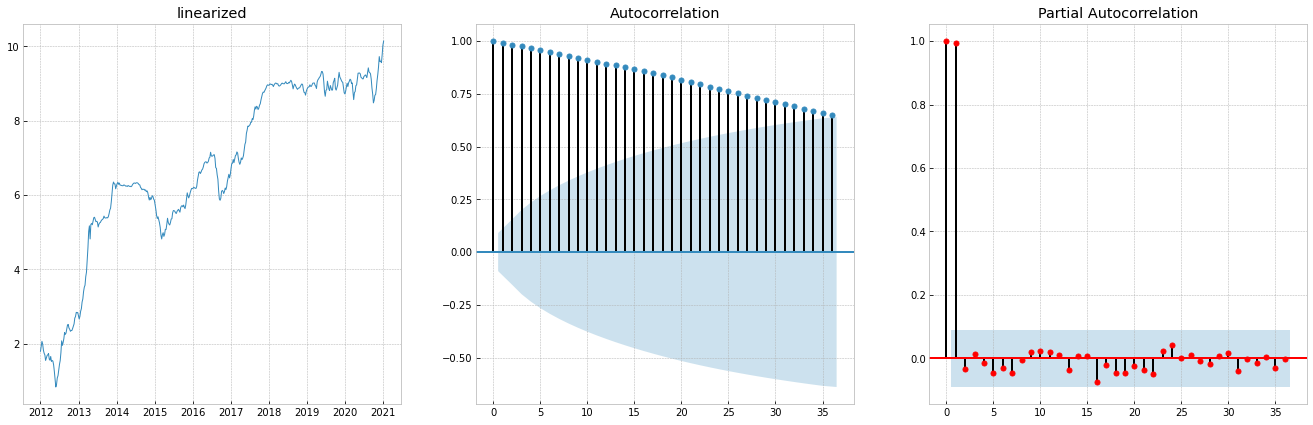

In [188]:
y = bitcoin["linearized"]

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))
axes[0].plot(y, linewidth=1); axes[0].set_title('linearized')
plot_acf(y, ax = axes[1], lags = FREQ * LAGS_BIAS);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS);

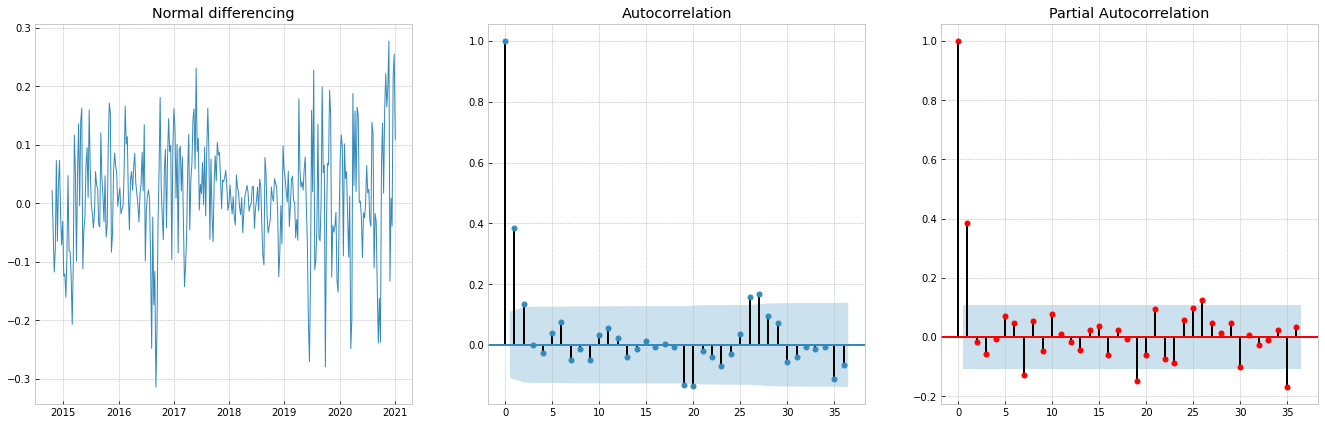

In [189]:
y = difference["Normal differencing"]

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))
axes[0].plot(y, linewidth=1); axes[0].set_title('Normal differencing')
plot_acf(y, ax = axes[1], lags = FREQ * LAGS_BIAS);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS);

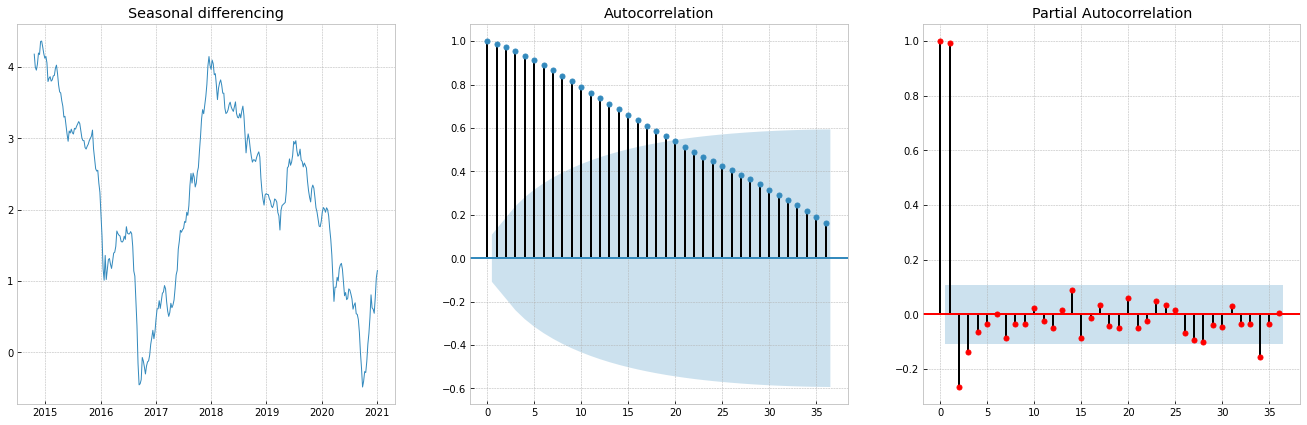

In [190]:
y = difference["Seasonal differencing"]

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))
axes[0].plot(y, linewidth=1); axes[0].set_title('Seasonal differencing')
plot_acf(y, ax = axes[1], lags = FREQ * LAGS_BIAS);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS);

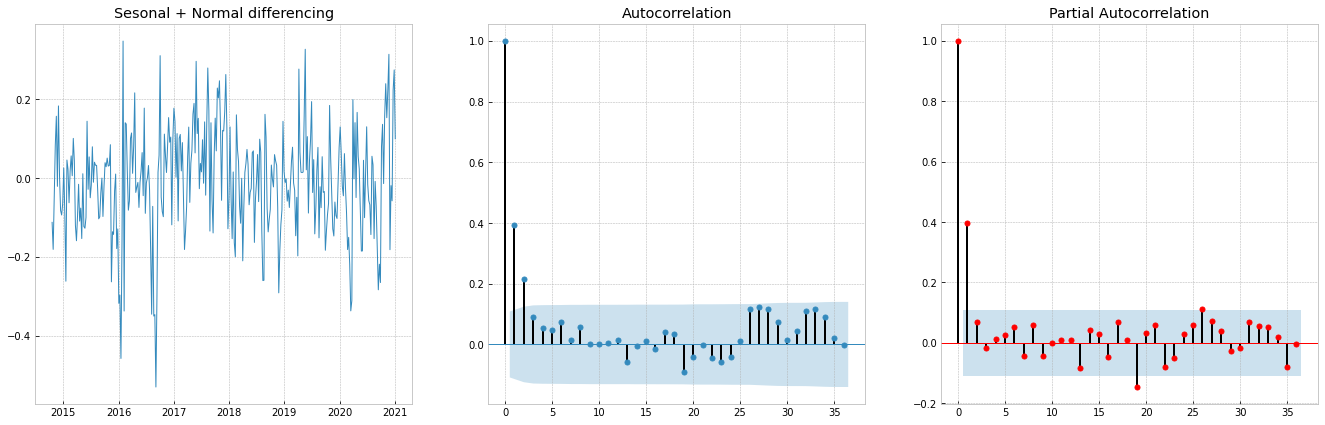

In [191]:
y = difference["Sesonal + Normal differencing"]

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))
axes[0].plot(y, linewidth=1); axes[0].set_title('Sesonal + Normal differencing')
plot_acf(y, ax = axes[1], lags = FREQ * LAGS_BIAS, linewidth=1);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS, linewidth=1);

## STEP 2 | Seasonal differencing (D)

In [192]:
# bitcoin_train["Normal differencing"] = bitcoin_train["linearized"].diff(1)
# bitcoin_train["Seasonal differencing"] = bitcoin_train["linearized"].diff(12)
# bitcoin_train["Sesonal + Normal differencing"] = bitcoin_train["linearized"].diff(12).diff(1)

In [193]:
bitcoin_train = bitcoin_train.dropna()

bitcoin_train.head(3)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,log,deseasonalized,linearized
date,,,,,,,,,,,
2012-01-01,1.325419e+09,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576,1.560813,6.002018,1.792096
2012-01-08,1.325765e+09,5.938663,5.948863,5.938651,5.948851,6.837477,37.261783,5.942655,1.773830,6.862411,1.926059
2012-01-15,1.326370e+09,6.763291,6.764704,6.753707,6.755134,3.011501,20.912794,6.758309,1.909429,7.839505,2.059176


## STEP 3 | Differencing (d)

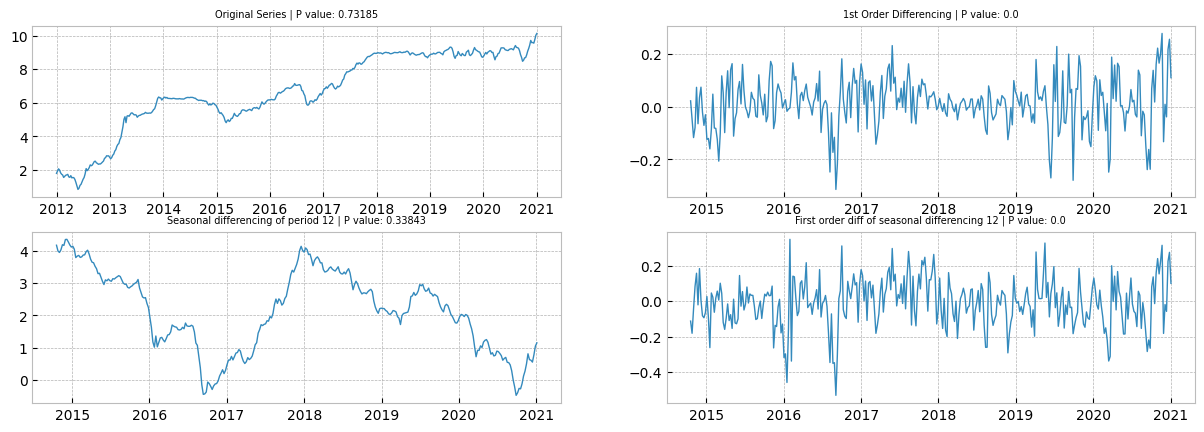

In [194]:
fig, axs = plt.subplots(2, 2, figsize=(15,5), dpi = 100, facecolor = (STYLE))
# Original series
axs[0,0].plot(bitcoin["linearized"], linewidth=1); axs[0,0].set_title(f'Original Series | P value: {round(adfuller(bitcoin_train["linearized"])[1], 5)}', fontsize= 7)

# Normal differencing
axs[0,1].plot(difference["Normal differencing"], linewidth=1); axs[0,1].set_title(f'1st Order Differencing | P value: {round(adfuller(difference["Normal differencing"].dropna())[1], 5)}', fontsize= 7)

# Seasonal differencing
axs[1,0].plot(difference["Seasonal differencing"], linewidth=1)
axs[1,0].set_title(f'Seasonal differencing of period 12 | P value: {round(adfuller(difference["Seasonal differencing"].dropna())[1], 5)}', fontsize= 7)

# Sesonal + Normal differencing
axs[1,1].plot(difference["Sesonal + Normal differencing"], linewidth=1)
axs[1,1].set_title(f'First order diff of seasonal differencing 12 | P value: {round(adfuller(difference["Sesonal + Normal differencing"].dropna())[1], 5)}', fontsize= 7);

## STEP 4 | Model and Hyperparameters

### Auto ARIMA

In [195]:
# The autocorrelation plot (plot_acf) applied to your fully differentiated series allows you to select MA number (q)
# MA( q ) = number of lag beyond which the  ACF  of  Y(d+D)  cuts off
# The partial autocorrelation plot plot_pacf applied to your fully differentiated series allows you to select AR (p)
# AR( p ) = number of lags beyond which the  PACF  of  Y(d+D)  cuts off

In [196]:
COLUMN = "linearized"

In [213]:
smodel = pm.auto_arima(bitcoin_train[COLUMN],
                       seasonal=True,
                       m = FREQ, # frequency of series. Important to choose manually
                       stepwise=True, # only check most interesting combination. False will take way longer
                       start_p=0, max_p=4,
                       start_d=0, max_d=4,
                       start_q=0, max_q=4,
                       start_P=0, max_P=4,
                       start_D=0, max_D=4,
                       start_Q=0, max_Q=4,
                       njobs=-1, trace=True, error_action='ignore', suppress_warnings=True)

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[145] intercept   : AIC=-600.371, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[145] intercept   : AIC=-647.508, Time=22.06 sec
 ARIMA(0,1,1)(0,0,1)[145] intercept   : AIC=-638.607, Time=30.66 sec
 ARIMA(0,1,0)(0,0,0)[145]             : AIC=-586.049, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[145] intercept   : AIC=-649.283, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[145] intercept   : AIC=-647.533, Time=34.84 sec
 ARIMA(1,1,0)(1,0,1)[145] intercept   : AIC=inf, Time=121.79 sec
 ARIMA(2,1,0)(0,0,0)[145] intercept   : AIC=-649.608, Time=0.22 sec
 ARIMA(2,1,0)(1,0,0)[145] intercept   : AIC=-647.732, Time=40.37 sec
 ARIMA(2,1,0)(0,0,1)[145] intercept   : AIC=-647.746, Time=33.01 sec
 ARIMA(2,1,0)(1,0,1)[145] intercept   : AIC=inf, Time=103.34 sec
 ARIMA(3,1,0)(0,0,0)[145] intercept   : AIC=-651.271, Time=0.27 sec
 ARIMA(3,1,0)(1,0,0)[145] intercept   : AIC=-649.525, Time=68.67 sec
 ARIMA(3,1,0)(0,0,1)[145] intercept   : AIC=-649.553, Time=47.54 sec
 ARI

In [214]:
# Forecast
n_periods = len(bitcoin_test[COLUMN]) # chequea cual es el largo del test set
central, confint = smodel.predict(n_periods = n_periods, return_conf_int = True) # Y lo pasa aca como el numero de periodos a predecir
index_y_test = bitcoin_test.index # pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index = index_y_test)
lower = pd.Series(confint[:, 0], index = index_y_test)
upper = pd.Series(confint[:, 1], index = index_y_test)

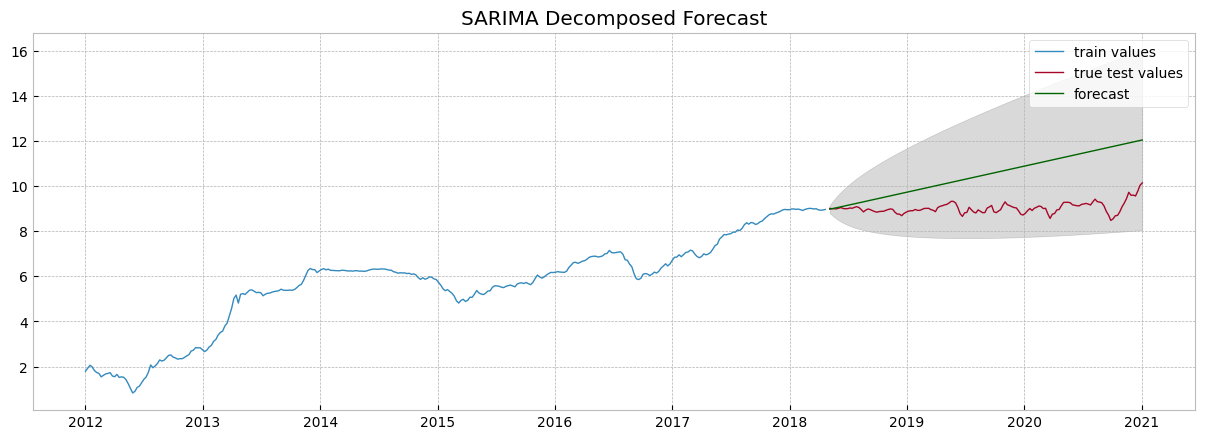

In [215]:
# Plot the linearized
plt.figure(figsize=(15,5), dpi=100, facecolor = (STYLE))
plt.plot(bitcoin_train[COLUMN], label = "train values", linewidth=1)
plt.plot(bitcoin_test[COLUMN], label = "true test values", linewidth=1)
plt.plot(central, color='darkgreen',label = "forecast", linewidth=1)
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha = .15)

plt.title("SARIMA Decomposed Forecast")
plt.legend()
plt.show()

In [216]:
# re-compose back to initial time series

forecast_recompose = np.exp(central) * decomp_mult.seasonal[index + 1:]
train_recompose = np.exp(bitcoin_train[COLUMN]) * decomp_mult.seasonal[0:index + 1]
test_recompose = np.exp(bitcoin_test[COLUMN]) * decomp_mult.seasonal[index + 1:]
lower_recompose = np.exp(confint)[:,0] * decomp_mult.seasonal[index + 1:] # Confidence interval
upper_recompose = np.exp(confint)[:,1] * decomp_mult.seasonal[index + 1:]

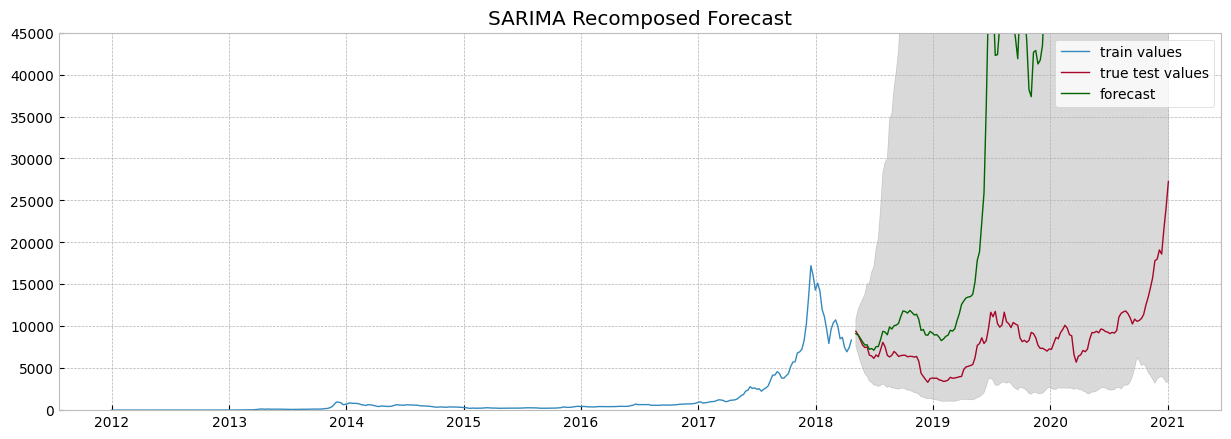

In [217]:
# Plot
plt.figure(figsize=(15,5), dpi=100, facecolor = (STYLE))
plt.ylim(0, 45000)
plt.plot(train_recompose, label = "train values", linewidth=1)
plt.plot(test_recompose, label = "true test values", linewidth=1)
plt.plot(forecast_recompose, color='darkgreen',label = "forecast", linewidth=1)
plt.fill_between(lower_recompose.index, 
                 lower_recompose, 
                 upper_recompose, 
                 color='k', alpha=.15)

plt.title("SARIMA Recomposed Forecast")
plt.legend()
plt.show()

In [218]:
# # Plot mas a futuro

# central, confint = smodel.predict(n_periods = n_periods + 100, return_conf_int = True)

# dti = pd.date_range(bitcoin_test.index.values[0], periods = n_periods + 100, freq = RESAMPLE)

# central = pd.Series(central, index = dti)

# # re-compose back to initial time series

# forecast_recompose = np.exp(central) * decomp_mult.seasonal[index + 1:] # los valores nan me llevan la multiplicacion a nada
# train_recompose = np.exp(bitcoin_train[COLUMN]) * decomp_mult.seasonal[0:index + 1]
# test_recompose = np.exp(bitcoin_test[COLUMN]) * decomp_mult.seasonal[index + 1:]
# lower_recompose = np.exp(confint)[:,0] * decomp_mult.seasonal[index + 1:] # Confidence interval
# upper_recompose = np.exp(confint)[:,1] * decomp_mult.seasonal[index + 1:]

# plt.figure(figsize=(15,5), dpi=100, facecolor = (STYLE))

# plt.plot(train_recompose, label = "train values")
# plt.plot(test_recompose, label = "true test values")
# plt.plot(forecast_recompose, color='darkgreen',label = "forecast")

# plt.legend()
# plt.show()

### SARIMA

In [219]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
# Build Model
sarima = SARIMAX(bitcoin_train[COLUMN], order=(1, 1, 0),seasonal_order=(0,0,1,63)) # SARIMA(p,d,q)(P,D,Q)[S] | BEST = (1,1,0)(0,0,1,63)
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(bitcoin_test), alpha = 0.05)
central = results.predicted_mean
confint = results.conf_int()

In [220]:
# re-compose back to initial time series

forecast_recompose = np.exp(central) * decomp_mult.seasonal[index + 1:]
train_recompose = np.exp(bitcoin_train[COLUMN]) * decomp_mult.seasonal[0:index + 1]
test_recompose = np.exp(bitcoin_test[COLUMN]) * decomp_mult.seasonal[index + 1:]
lower_recompose = np.exp(confint[f"lower {COLUMN}"]) * decomp_mult.seasonal[index + 1:] # Confidence interval
upper_recompose = np.exp(confint[f"upper {COLUMN}"]) * decomp_mult.seasonal[index + 1:]


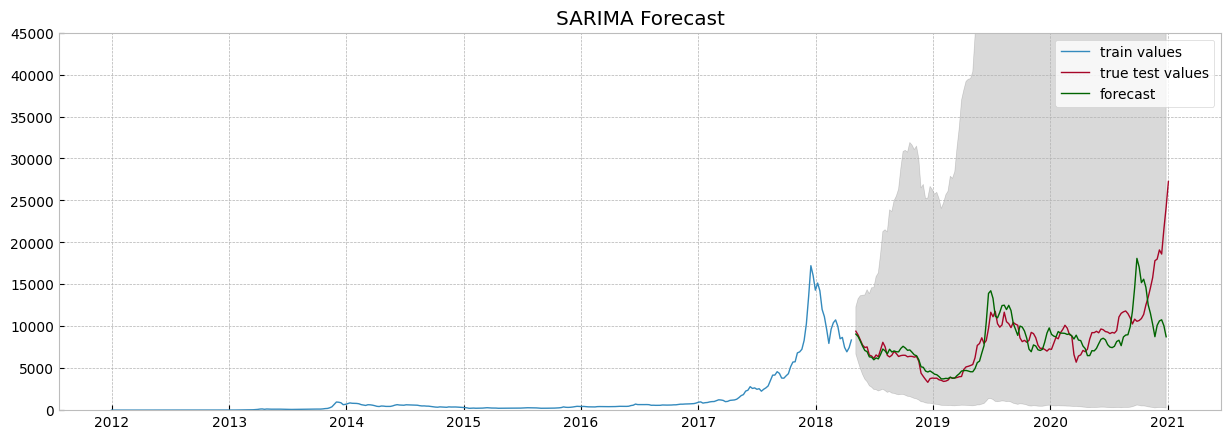

In [221]:
# Plot
plt.figure(figsize=(15,5), dpi=100, facecolor = (STYLE))
plt.ylim(0,45000)
plt.plot(train_recompose, label = "train values", linewidth=1)
plt.plot(test_recompose, label = "true test values", linewidth=1)
plt.plot(forecast_recompose, color='darkgreen',label = "forecast", linewidth=1)
plt.fill_between(lower_recompose.index, 
                 lower_recompose, 
                 upper_recompose, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [222]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           linearized   No. Observations:                  330
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 63)   Log Likelihood                 324.061
Date:                              Thu, 28 Jan 2021   AIC                           -642.122
Time:                                      23:16:49   BIC                           -630.734
Sample:                                  01-01-2012   HQIC                          -637.579
                                       - 04-22-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4089      0.032     12.776      0.000       0.346       0.472
ma.S.L63       0.0201      0.082      0.246      0.806      -0.141       0.181
sigma2         0.0082      0.000     20.888      0.000       0.007       0.009
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):               328.24
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMAX

In [223]:
exo = ["Volume_(Currency)", "Volume_(BTC)"] # , "Open", "High", "Low", "Close", "log"]

sarimax = SARIMAX(endog=bitcoin_train[COLUMN],
        exog = bitcoin_train[exo],
        order = (1, 1, 0), seasonal_order = (0,0,1,63) # SARIMA(p,d,q)(P,D,Q)[S] | BEST = (1,1,0)(0,0,1,63)
       )

sarimax = sarimax.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [224]:
# Forecast
results = sarimax.get_forecast(len(bitcoin_test), exog = bitcoin_test[exo], dynamic= True, alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

In [225]:
# re-compose back to initial time series

forecast_recompose = np.exp(central) * decomp_mult.seasonal[index + 1:]
train_recompose = np.exp(bitcoin_train[COLUMN]) * decomp_mult.seasonal[0:index + 1]
test_recompose = np.exp(bitcoin_test[COLUMN]) * decomp_mult.seasonal[index + 1:]
lower_recompose = np.exp(confint[f"lower {COLUMN}"]) * decomp_mult.seasonal[index + 1:] # Confidence interval
upper_recompose = np.exp(confint[f"upper {COLUMN}"]) * decomp_mult.seasonal[index + 1:]

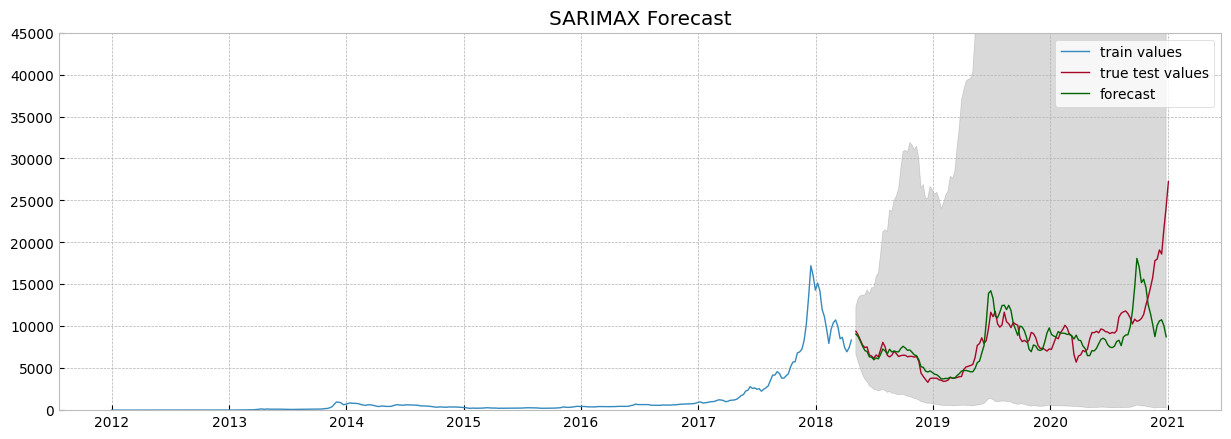

In [226]:
# Plot
plt.figure(figsize=(15,5), dpi=100, facecolor = (STYLE))
plt.ylim(0,45000)
plt.plot(train_recompose, label = "train values", linewidth=1)
plt.plot(test_recompose, label = "true test values", linewidth=1)
plt.plot(forecast_recompose, color='darkgreen',label = "forecast", linewidth=1)
plt.fill_between(lower_recompose.index, 
                 lower_recompose, 
                 upper_recompose, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast")
plt.legend()
plt.show()

In [227]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           linearized   No. Observations:                  330
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 63)   Log Likelihood                 319.827
Date:                              Thu, 28 Jan 2021   AIC                           -629.654
Time:                                      23:17:01   BIC                           -610.674
Sample:                                  01-01-2012   HQIC                          -622.082
                                       - 04-22-2018                                         
Covariance Type:                                opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Volume_(Currency)  6.589e-08   9.08e-07      0.073      0.942   -1.71e-06    1.84e-06
Volume_(BTC)         -0.0007      0.001     -0.899      0.369      -0.002       0.001
ar.L1                 0.4065      0.032     12.885      0.000       0.345       0.468
ma.S.L63             -0.1589      0.068     -2.320      0.020      -0.293      -0.025
sigma2                0.0081      0.000     20.570      0.000       0.007       0.009
===================================================================================
Ljung-Box (L1) (Q):                   1.42   Jarque-Bera (JB):               264.48
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [228]:
raise SystemExit("Stop right there!")

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# PRUEBAS

In [ ]:
# str(list(np.arange(6,160,6)))

In [ ]:
# for f in [6, 12, 18, 24, 30, 36]:
#   pmodel = pm.auto_arima(bitcoin_train[COLUMN],
#                         seasonal=True,
#                         m = f, # frequency of series. Important to choose manually
#                         stepwise=True, # only check most interesting combination. False will take way longer
#                         start_p=0, max_p=3,
#                         start_d=0, max_d=3,
#                         start_q=0, max_q=3,
#                         start_P=0, max_P=3,
#                         start_D=0, max_D=3,
#                         start_Q=0, max_Q=3,
#                         njobs=-1, trace=True, error_action='ignore', suppress_warnings=True)

# print(pmodel.summary())

In [ ]:
# # Forecast
# n_periods = len(bitcoin_test[COLUMN]) # chequea cual es el largo del test set
# central, confint = pmodel.predict(n_periods = n_periods, return_conf_int = True) # Y lo pasa aca como el numero de periodos a predecir
# index_y_test = bitcoin_test.index # pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# # make series for plotting purpose
# central = pd.Series(central, index = index_y_test)
# lower = pd.Series(confint[:, 0], index = index_y_test)
# upper = pd.Series(confint[:, 1], index = index_y_test)

In [ ]:
# # Plot
# plt.figure(figsize=(15,5), dpi=100, facecolor = (STYLE))
# plt.plot(bitcoin_train[COLUMN], label = "train values")
# plt.plot(bitcoin_test[COLUMN], label = "true test values")
# plt.plot(central, color='darkgreen',label = "forecast")
# plt.fill_between(lower.index, 
#                  lower, 
#                  upper, 
#                  color='k', alpha=.15)

# plt.title("SARIMA Forecast")
# plt.legend()
# plt.show()